# DTSA 5511 Introduction to Deep Learning Final Project
### Topic: Image Classification with Convolutional Neural Networks on Vehicle Dataset

## Background

In this final project, we are going to build models to classify images of vehicles. The dataset we are going to use is the [Kaggle Vehicle Dataset](https://www.kaggle.com/datasets/kaggleashwin/vehicle-type-recognition/data). The goal of this project is to build a CNN model that can classify images of vehicles into the correct class.

This project has the incentive to explore the application of deep learning in image classification. The dataset is relatively small, which makes it a good starting point for beginners to practice building CNN models.

Besides, upon finishing the model, it can be further developed into a vehicle recognition system that can be used in real-world applications, such as traffic monitoring, vehicle tracking, and security surveillance.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import cv2
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Nadam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50, MobileNetV2
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import BatchNormalization

from sklearn.model_selection import train_test_split

import keras_tuner
from keras_tuner import RandomSearch

2025-03-01 16:09:26.589440: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-01 16:09:26.643078: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740816566.673081    6067 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740816566.684110    6067 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-01 16:09:26.740089: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Exploratory Data Analysis (EDA)
### Describe the data

In [2]:
data_dir = 'Dataset'
class_names = os.listdir(data_dir)
num_classes = len(class_names)

first_class_dir = os.path.join(data_dir, class_names[0])
first_image_path = os.path.join(first_class_dir, os.listdir(first_class_dir)[0])
sample_image = cv2.imread(first_image_path)
image_height, image_width, image_channels = sample_image.shape

In [3]:
print("Class count:", num_classes)
print("height:", image_height, "width:", image_width, "channels:", image_channels)

Class count: 4
height: 400 width: 600 channels: 3


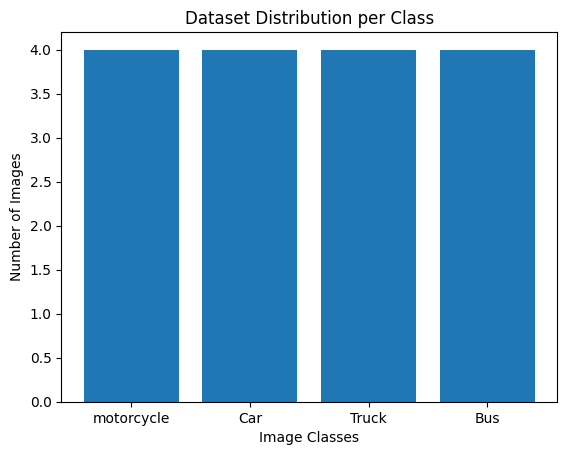

In [4]:
plt.bar(class_names, 4)
plt.xlabel('Image Classes')
plt.ylabel('Number of Images')
plt.title('Dataset Distribution per Class')
plt.show()

Per barplot, the data is evenly distributed between the 4 classes. The data is not imbalanced.
### Image preview

In [5]:
# Function to display image samples from a dataset
def display_image_samples(data_dir, class_names, num_samples_per_class):
    for class_name in class_names:
        class_path = os.path.join(data_dir, class_name)
        image_filenames = os.listdir(class_path)
        random.shuffle(image_filenames)
        
        fig, axs = plt.subplots(1, num_samples_per_class, figsize=(12, 4))
        
        for i in range(num_samples_per_class):
            image_path = os.path.join(class_path, image_filenames[i])
            sample_image = cv2.imread(image_path)
            sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
            
            axs[i].imshow(sample_image)
            axs[i].axis('off')
            axs[i].set_title(f'Sample {i+1}')
        
        fig.suptitle(class_name, fontsize=14, fontweight='bold')
        plt.show()

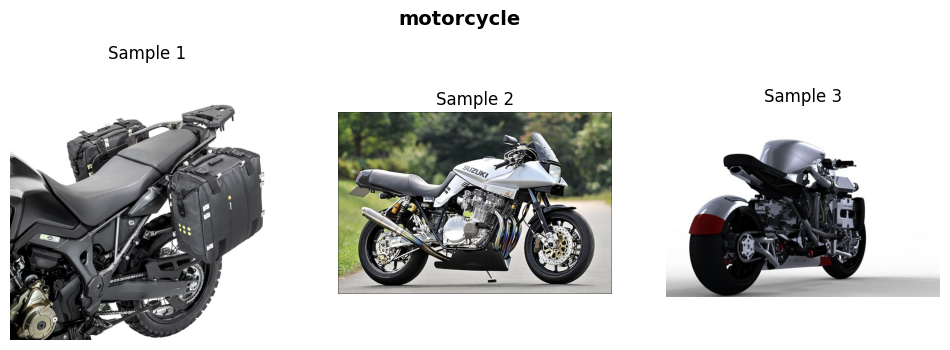

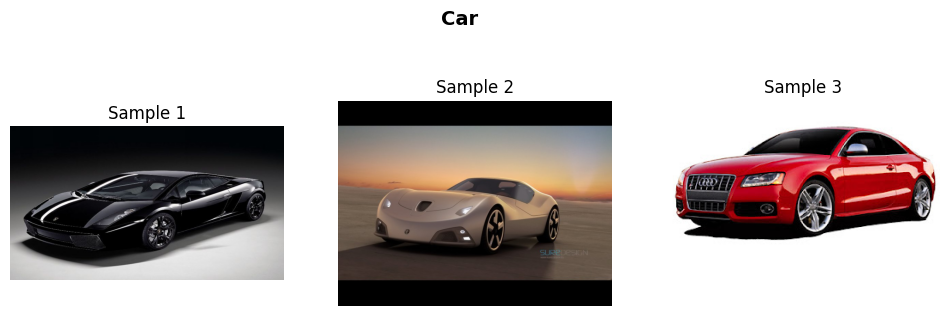

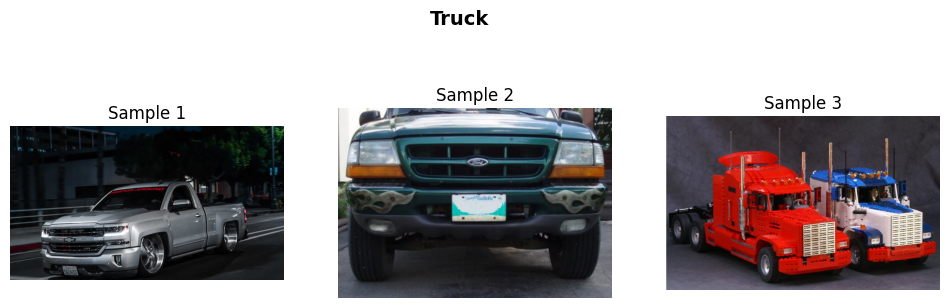

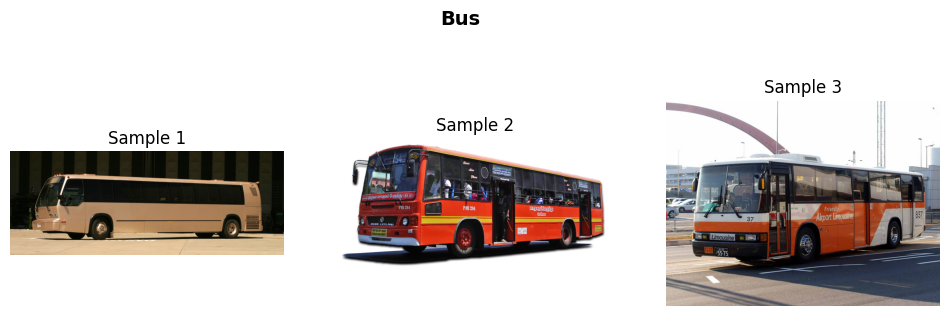

In [6]:
data_dir = 'Dataset'
num_samples_per_class = 3

class_names = os.listdir(data_dir)

display_image_samples(data_dir, class_names, num_samples_per_class)

Per inspection, images are:
- From various sources and various dimensions
- not preprocessed and are in their raw form
- not in grayscale and are in RGB format
- not normalized and are in their raw pixel values

Therefore, we are going to preprocess the images.

In [7]:
# Function to obtain image dimension statistics
def get_image_stats(data_dir, class_names):
    image_stats = []

    for class_name in class_names:
        class_path = os.path.join(data_dir, class_name)
        image_filenames = os.listdir(class_path)

        for image_filename in image_filenames:
            image_path = os.path.join(class_path, image_filename)
            image = cv2.imread(image_path)
            image_stats.append(image.mean(axis=(0, 1)))

    image_stats = np.array(image_stats)
    mean_stats = image_stats.mean(axis=0)
    std_stats = image_stats.std(axis=0)

    print("Mean pixel values:", mean_stats)
    print("Standard deviation of pixel values:", std_stats)

In [8]:
get_image_stats(data_dir, class_names)

Mean pixel values: [114.06713775 118.03303583 123.34488098]
Standard deviation of pixel values: [41.74682924 39.56793569 40.1888138 ]


## Data Preprocessing
Resize images into a fixed dimension.

For models like ResNet-50, a common input size is 224x224 pixels. This size is a good balance between detail and computational efficiency.

Then split the data into training, validation and testing sets.

In [9]:
# Create a dataframe to store image paths and corresponding labels
image_paths = []
image_labels = []

for class_name in class_names:
    class_path = os.path.join(data_dir, class_name)
    image_filenames = os.listdir(class_path)

    for image_filename in image_filenames:
        image_path = os.path.join(class_path, image_filename)
        image_paths.append(image_path)
        image_labels.append(class_name)
        
data = {
    'image_path': image_paths,
    'label': image_labels
}

df = pd.DataFrame(data)
df.head()
        

,image_path,label
0,Dataset/motorcycle/Image_26.jpg,motorcycle
1,Dataset/motorcycle/Image_97.JPG,motorcycle
2,Dataset/motorcycle/Image_71.jpg,motorcycle
3,Dataset/motorcycle/Image_49.jpg,motorcycle
4,Dataset/motorcycle/Image_85.jpeg,motorcycle


### Split the dataframe into training, validation and testing sets

In [10]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 420)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 420)

In [11]:
data_dir = 'Dataset'
image_size = (224, 224)  # Desired fixed size
batch_size = 32

# Create a data generator for training images
data_generator = ImageDataGenerator(
    preprocessing_function=lambda x: x,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.4,0.6],
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True
    )



In [12]:
# Flow from directory with specified batch size and target image size
train_generator = data_generator.flow_from_dataframe(
    train_df,
    directory=None,
    x_col='image_path',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode= 'rgb', 
    shuffle=True
)

validation_generator = data_generator.flow_from_dataframe(
    valid_df,
    directory=None,
    x_col='image_path',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode= 'rgb', 
    shuffle=True
)

test_generator = data_generator.flow_from_dataframe(
    test_df,
    directory=None,
    x_col='image_path',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode= 'rgb', 
    shuffle=False
)

Found 320 validated image filenames belonging to 4 classes.
Found 48 validated image filenames belonging to 4 classes.
Found 32 validated image filenames belonging to 4 classes.


## Model architectures
### Homebrew CNN

We will start with a simple CNN model as baseline.

In [13]:
# Set the seed for reproducibility
np.random.seed(420)
tf.random.set_seed(1)
channels = 3

# Define the CNN model architecture
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(*image_size, channels)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(len(class_names), activation='softmax')
])
cnn_model.summary()


/home/tc/Github/MSDS-deep-learning/env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1740816586.793686    6067 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5632 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Compile the model
cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )

# Train the model
history = cnn_model.fit(train_generator,epochs=10,validation_data=validation_generator)

/home/tc/Github/MSDS-deep-learning/env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


/home/tc/Github/MSDS-deep-learning/env/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
I0000 00:00:1740816590.506012    6194 service.cc:148] XLA service 0x7ff75c0046d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740816590.506109    6194 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-03-01 16:09:50.530702: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740816590.730972    6194 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/10 ━━━━━━━━━━━━━━━━━━━━ 1:05 7s/step - accuracy: 0.3125 - loss: 10.4304

I0000 00:00:1740816596.160341    6194 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 963ms/step - accuracy: 0.3008 - loss: 214.6366 - val_accuracy: 0.2292 - val_loss: 1.6227
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 656ms/step - accuracy: 0.2800 - loss: 1.4278 - val_accuracy: 0.2500 - val_loss: 1.3654
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 643ms/step - accuracy: 0.2741 - loss: 1.3849 - val_accuracy: 0.3542 - val_loss: 1.3625
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 641ms/step - accuracy: 0.2881 - loss: 1.3604 - val_accuracy: 0.3750 - val_loss: 1.3597
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 646ms/step - accuracy: 0.2901 - loss: 1.3709 - val_accuracy: 0.2083 - val_loss: 1.3660
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 702ms/step - accuracy: 0.3529 - loss: 1.3598 - val_accuracy: 0.1667 - val_loss: 1.3665
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 642ms/step - accuracy: 0.3952 - loss: 1.3362 - val_accuracy: 0.2917 - val_loss: 1.3556
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 616ms/step - accuracy: 0.3717 - loss: 1.3540 - val_accuracy: 0.2500 - v

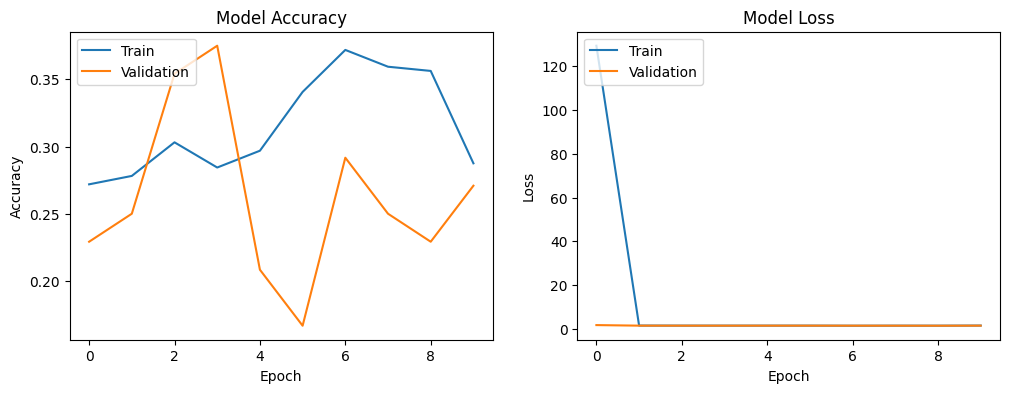

In [15]:
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

plot_training_history(history)

From the plot, we can see that the model is not generalizing well to the validation set.

### CNN with increased depth
We will increase the depth of the CNN model to see if it can improve the model performance.

In [16]:
# Increased depth of CNN
cnn_model_more_depth = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(*image_size, channels)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(len(class_names), activation='softmax')
])
cnn_model_more_depth.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,718,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,107,652 (19.48 MB)

 Trainable params: 5,107,652 (19.48 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
cnn_model_more_depth.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )

# Train the model
history = cnn_model.fit(train_generator,epochs=10,validation_data=validation_generator)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 708ms/step - accuracy: 0.3538 - loss: 1.3289 - val_accuracy: 0.2083 - val_loss: 1.3828
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 682ms/step - accuracy: 0.3188 - loss: 1.3531 - val_accuracy: 0.2708 - val_loss: 1.3711
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 642ms/step - accuracy: 0.3526 - loss: 1.3267 - val_accuracy: 0.3333 - val_loss: 1.3583
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 628ms/step - accuracy: 0.3006 - loss: 1.3277 - val_accuracy: 0.2917 - val_loss: 1.3230
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 663ms/step - accuracy: 0.2967 - loss: 1.4193 - val_accuracy: 0.2917 - val_loss: 1.3321
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 623ms/step - accuracy: 0.3228 - loss: 1.3328 - val_accuracy: 0.3333 - val_loss: 1.2572
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 636ms/step - accuracy: 0.3428 - loss: 1.3419 - val_accuracy: 0.2917 - val_loss: 1.3305
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 677ms/step - accuracy: 0.3539 - loss: 1.3078 - val_accuracy: 0.

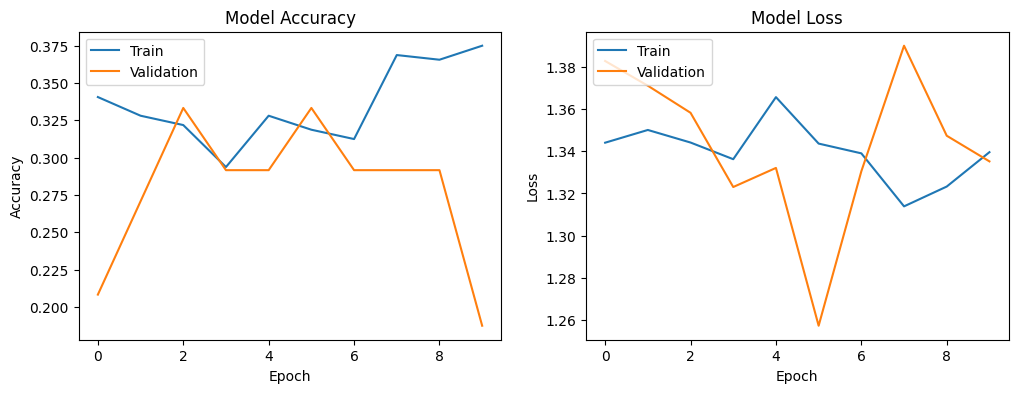

In [18]:
plot_training_history(history)

Not much improvement in the model performance. The model is still overfitting.

### CNN Model with Batch Normalization
We will add batch normalization to the CNN model to see if it can improve the model performance.

In [19]:
cnn_model_normalized = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(*image_size, channels)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(len(class_names), activation='softmax')
])

# Compile and train the model
cnn_model_normalized.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

history = cnn_model_normalized.fit(train_generator,epochs=10,validation_data=validation_generator)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 756ms/step - accuracy: 0.2059 - loss: 33.2827 - val_accuracy: 0.2083 - val_loss: 151.5648
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 655ms/step - accuracy: 0.2628 - loss: 11.3506 - val_accuracy: 0.2708 - val_loss: 45.7200
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 637ms/step - accuracy: 0.3287 - loss: 7.3356 - val_accuracy: 0.2708 - val_loss: 14.9637
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 599ms/step - accuracy: 0.2633 - loss: 3.3313 - val_accuracy: 0.3750 - val_loss: 2.0565
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 617ms/step - accuracy: 0.3197 - loss: 2.0108 - val_accuracy: 0.3333 - val_loss: 1.4126
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 681ms/step - accuracy: 0.2584 - loss: 1.9896 - val_accuracy: 0.3333 - val_loss: 1.3363
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 657ms/step - accuracy: 0.2650 - loss: 1.4574 - val_accuracy: 0.2917 - val_loss: 1.6665
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 610ms/step - accuracy: 0.2541 - loss: 1.4118 - val_accu

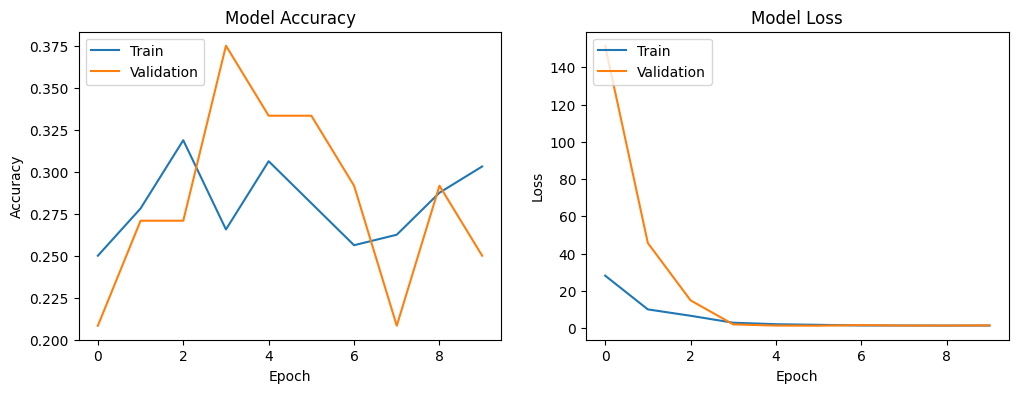

In [20]:
plot_training_history(history)

The model is still overfitting. The model is not generalizing well to the validation set.

The possible reason that our homebrew CNN is not performing well is that the dataset is relatively small. The model is too complex for the small dataset, which leads to overfitting. We will try to use a pre-trained model to see if it can improve the model performance.

## Pre-trained model
Below I have chosen a couple of pre-trained models to use for transfer learning. I will use the pre-trained models to extract features from the images and then use these features to train a classifier.

Advantages of using pre-trained models:
- Pre-trained models have already been trained on large datasets and have learned features that are useful for a wide range of tasks.
- Using pre-trained models can save time and computational resources.

Therefore, I will experiment with different pre-trained models to see which one works best for this task.

1. ResNet50
2. EfficentNet
2. MobileNetV2

### ResNet50

In [21]:
# Load the ResNet50 model with pre-trained weights, excluding the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(*image_size, channels))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(len(class_names), activation='softmax')(x)

# Create the final model
resnet_model = Model(inputs=base_model.input, outputs=predictions)
resnet_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,638,852 (93.99 MB)

 Trainable params: 24,585,732 (93.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

Epoch 1/10


2025-03-01 16:13:37.112825: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4989_0', 112 bytes spill stores, 224 bytes spill loads

2025-03-01 16:13:38.033515: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4989', 220 bytes spill stores, 576 bytes spill loads

2025-03-01 16:13:38.600064: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5209', 60 bytes spill stores, 64 bytes spill loads

2025-03-01 16:13:38.636474: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5209', 24 bytes spill stores, 24 bytes spill loads

2025-03-01 16:13:39.020120: I external/local_xla/xla/s

10/10 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.4442 - loss: 2.2850 - val_accuracy: 0.6667 - val_loss: 1.0917
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 638ms/step - accuracy: 0.6673 - loss: 0.8311 - val_accuracy: 0.7083 - val_loss: 0.5786
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 658ms/step - accuracy: 0.8235 - loss: 0.4621 - val_accuracy: 0.8542 - val_loss: 0.4723
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 655ms/step - accuracy: 0.8909 - loss: 0.2665 - val_accuracy: 0.8125 - val_loss: 0.4219
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 633ms/step - accuracy: 0.9012 - loss: 0.2733 - val_accuracy: 0.8333 - val_loss: 0.4106
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 666ms/step - accuracy: 0.9016 - loss: 0.2586 - val_accuracy: 0.8542 - val_loss: 0.3413
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 676ms/step - accuracy: 0.9295 - loss: 0.2034 - val_accuracy: 0.7917 - val_loss: 0.4231
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 647ms/step - accuracy: 0.9123 - loss: 0.2090 - val_accuracy: 0.8125 - val_l

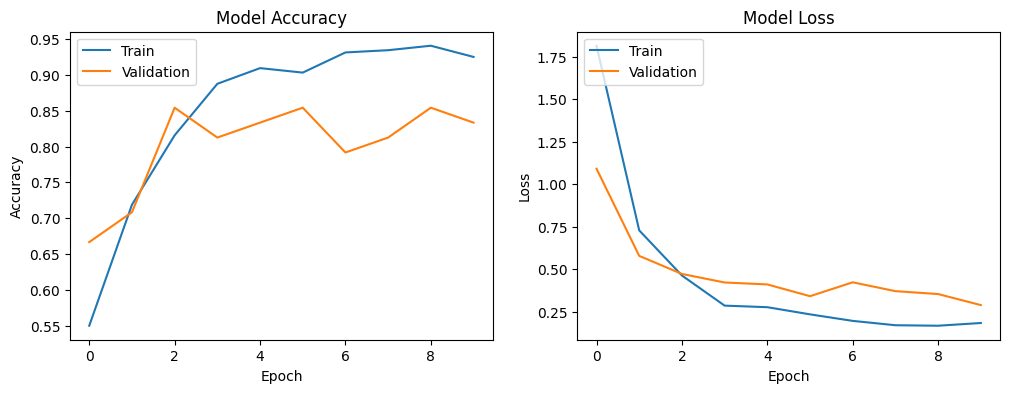

In [22]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
resnet_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model and store the training history
history = resnet_model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

# Call the function to plot the training history
plot_training_history(history)

Per inspection, the model accuracy is at highest of 0.854 and the model loss is at lowest of 0.341. It shows a significant improvement compared to the homebrew CNN model. The model is not overfitting and is generalizing well to the validation set.

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9649 - loss: 0.1166 - val_accuracy: 0.8750 - val_loss: 0.3572
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 672ms/step - accuracy: 0.9530 - loss: 0.1216 - val_accuracy: 0.8333 - val_loss: 0.3915
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 608ms/step - accuracy: 0.9630 - loss: 0.1377 - val_accuracy: 0.8542 - val_loss: 0.3390
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 633ms/step - accuracy: 0.9573 - loss: 0.1288 - val_accuracy: 0.8125 - val_loss: 0.3485
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 672ms/step - accuracy: 0.9662 - loss: 0.1247 - val_accuracy: 0.8958 - val_loss: 0.2936
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 663ms/step - accuracy: 0.9451 - loss: 0.1484 - val_accuracy: 0.8125 - val_loss: 0.4769
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 642ms/step - accuracy: 0.9417 - loss: 0.1564 - val_accuracy: 0.8958 - val_loss: 0.3331
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 652ms/step - accuracy: 0.9516 - loss: 0.1232 - val_accuracy: 0.85

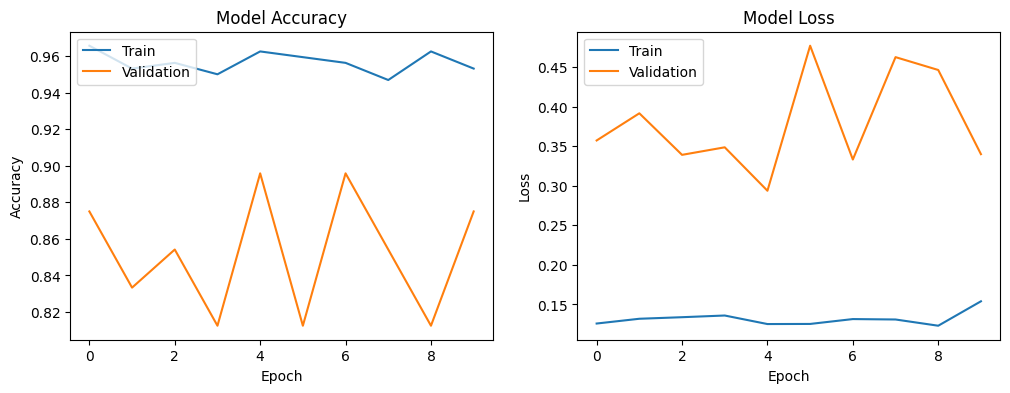

In [23]:
# Recompile the model with a low learning rate
resnet_model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.SGD(learning_rate=0.00009), 
    metrics=['accuracy']
    )

# Train the model and store the training history
history = resnet_model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

# Call the function to plot the training history
plot_training_history(history)

This model with lowest learning rate shows much higher training accuracy and lower training model loss. However, these statistics for validation set is similar to the model with higher learning rate. We will proceed to test further with testing set later. 